# Run these

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import joblib
import os
# from sklearn.feature_selection import mutual_info_regression

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit 
from sklearn.metrics import ConfusionMatrixDisplay


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import yfinance as yf
from decimal import Decimal
warnings.filterwarnings("ignore")

# df must have index as datetime64[ns], and 'signal' column
# freq can be 'd', 'h', '5min', or '15min'
def run_backtest(df, freq='d'):

  # check if df.index is datetime64[ns]
  if df.index.dtype != 'datetime64[ns]':
    raise ValueError("df.index must be in datetime64[ns]")

  # ------------------ Return Data Preparation ------------------
  if 'return_forward' in df.columns:
    df = df.drop(columns=['return_forward'])

  if freq == 'd':
    df = concat_return(df, freq)
    period_in_a_year = 365
  elif freq == 'h':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24
  elif freq == '5min':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24 * 12
  elif freq == '15min':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24 * 4
  else:
    raise ValueError("Invalid freq argument. Must be 'd', 'h', '5min', or '15min'")

  # ------------------ Data check ------------------
  if df['signal'].isnull().values.any():
    raise ValueError("DataFrame contains NA values")
  if 'signal' not in df.columns:
    raise ValueError("DataFrame is missing required column: 'signal'")

  # ------------------ Return & Sharpe ------------------
  # Daily returns
  df['strategy_return'] = df['signal'] * df['return_forward']

  # Geometric Annual Return
  num_periods = len(df)
  annual_return_geometric = (1 + df['strategy_return']).prod()**(period_in_a_year/num_periods) - 1
  
  # Arithmetic Annual Return for sharpe ratio calculation
  annual_return_arithmetic = df['strategy_return'].mean() * period_in_a_year

  # Sharpe Ratio
  daily_std = df['strategy_return'].std()
  annual_std = daily_std * np.sqrt(period_in_a_year)
  overall_sharpe = annual_return_arithmetic / annual_std

  print(f"Overall Annual Return: {round(annual_return_geometric*100, 2)}%")
  print("Overall Annual Sharpe Ratio:", round(overall_sharpe, 4))

  # ------------------ Maximum Drawdown ------------------
  df['cum_return'] = (1 + df['strategy_return']).cumprod()
  rolling_max = df['cum_return'].cummax()
  df['drawdown'] = (df['cum_return'] - rolling_max) / rolling_max
  max_drawdown = df['drawdown'].min()
  print("Maximum Drawdown:", round(max_drawdown * 100, 2), "%")

  # ------------------ Win/Loss Ratio ------------------
  # winning_trades = (df['strategy_return'] > 0).sum()
  # losing_trades = (df['strategy_return'] < 0).sum()
  # if losing_trades > 0:
  #   win_loss_ratio = winning_trades / losing_trades
  # else:
  #   win_loss_ratio = np.nan # no losing trades (advoid division by zero)
  # print("Win/Loss Ratio:", round(win_loss_ratio, 4))

  # ------------------ Alpha and Beta ------------------
  # Beta = Cov(strategy_return, acutal_return) / Var(actual_return)
  cov_matrix = np.cov(df['strategy_return'], df['return_forward'])
  beta = cov_matrix[0, 1] / cov_matrix[1, 1]

  # Alpha = mean(strategy_return) - Beta * mean(actual_return)
  alpha_daily = df['strategy_return'].mean() - beta * df['return_forward'].mean()

  # Annualize alpha
  alpha_annualized = (1 + alpha_daily) ** period_in_a_year - 1

  print("Alpha:", round(alpha_annualized, 4))
  print("Beta:", round(beta, 4))

  # ------------------- Yearly Metrics -------------------
  df['year'] = df.index.year

  yearly_data = df.groupby('year').apply(lambda subdf: pd.Series({
    'yearly_return': (1 + subdf['strategy_return']).prod()**(period_in_a_year/len(subdf)) - 1,
    'yearly_return_arithmetic': subdf['strategy_return'].mean() * period_in_a_year,
    'yearly_std': subdf['strategy_return'].std() * np.sqrt(period_in_a_year),
    'yearly_beta': np.cov(subdf['strategy_return'], subdf['return_forward'])[0,1] /
                    np.cov(subdf['strategy_return'], subdf['return_forward'])[1,1],
    'yearly_alpha': (
      subdf['strategy_return'].mean()
      - (
        np.cov(subdf['strategy_return'], subdf['return_forward'])[0,1]
        / np.cov(subdf['strategy_return'], subdf['return_forward'])[1,1]
      )
      * subdf['return_forward'].mean()
    ) * period_in_a_year
  })).reset_index()

  yearly_data['yearly_sharpe'] = yearly_data['yearly_return_arithmetic'] / yearly_data['yearly_std']
  yearly_data.drop(columns=['yearly_return_arithmetic'], inplace=True)
  print("\nYearly Metrics:")
  print(yearly_data)

  # ------------------------- Plots ----------------------
  df['cum_return_plot'] = (1 + df['strategy_return']).cumprod() - 1
  df['bh_cum_return_plot'] = (1 + df['return_forward']).cumprod() - 1

  # cumulative return plot
  plt.figure(figsize=(8,4))
  plt.plot(df.index, df['cum_return_plot'], label='Strategy Return')
  plt.plot(df.index, df['bh_cum_return_plot'], label='Buy and Hold')
  plt.title('Strategy Cumulative Return')
  plt.xlabel('Date')
  plt.ylabel('Cumulative Return')
  plt.legend()
  plt.show()

  # Signal weight plot
  plt.figure(figsize=(8,4))
  plt.plot(df.index, df['signal'], label='Signal')
  plt.title('Signal Weight Over Time')
  plt.xlabel('Date')
  plt.ylabel('Weight')
  plt.legend()
  plt.show()


def concat_return(df, freq='d'):
  if freq == 'd':
    file_path = "../../bitcoin_historical_price/btcusd_daily_price.parquet"
  elif freq == 'h':
    file_path = "/workspaces/Bitcoin-Systematic-Strategies/bitcoin_historical_price/btcusd_hourly_price.parquet"
  elif freq == '5min':
    file_path = "../../bitcoin_historical_price/btcusd_5min_price.parquet"
  elif freq == '15min':
    file_path = "../../bitcoin_historical_price/btcusd_15min_price.parquet"
  else:
    raise ValueError("Invalid freq argument. Must be 'd', 'h', '5min', or '15min'")

  if os.path.exists(file_path):
    df_btc_return = pd.read_parquet(file_path)
  else:
    raise FileNotFoundError("Check file path: return data not found.")

  # merge return_forward to df
  merged_df = pd.merge(df, df_btc_return[['return_forward']], left_index=True, right_index=True, how='inner')

  # turn return_forward from decimal to float
  merged_df['return_forward'] = merged_df['return_forward'].apply(lambda x: float(x))
  return merged_df

# Import Data

In [15]:
df = pd.read_parquet("/workspaces/Bitcoin-Systematic-Strategies/modeling_backtesting/data/full_dataset_feature_engineering_v2.parquet", engine="pyarrow")
df.tail()

,news_count,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,return_forward,sma_5_20_diff,sma_20_50_diff,...,NER_michael saylor_last24,NER_microstrategy_last3,NER_microstrategy_last24,NER_sec_last3,NER_sec_last24,NER_us_last3,reddit_total_sentiment_ewm_5h,reddit_total_sentiment_ewm_24h,reddit_average_sentiment_ewm_5h,reddit_average_sentiment_ewm_24h
2024-12-31 19:00:00,7.0,0.342857,0.157143,0.114286,0.014286,0.471429,0.0,-0.006308,339.30,312.86,...,1,1,1,1,1,1,0.369066,0.208662,0.026292,0.015598
2024-12-31 20:00:00,6.0,0.216667,0.016667,0.083333,0.000000,0.483333,0.0,0.002858,-30.20,309.90,...,1,0,1,1,1,1,0.246044,0.191969,0.017528,0.014350
2024-12-31 21:00:00,3.0,0.100000,0.233333,0.200000,0.000000,0.300000,0.0,-0.004142,-238.45,313.73,...,1,0,1,1,1,1,0.164029,0.176611,0.011685,0.013202
2024-12-31 22:00:00,4.0,0.200000,0.200000,0.475000,0.000000,0.925000,0.0,0.000933,-365.30,310.76,...,1,0,1,0,1,1,0.319753,0.212978,0.017354,0.014441
2024-12-31 23:00:00,4.0,0.100000,0.150000,0.200000,0.000000,0.400000,0.0,0.000150,-434.50,301.66,...,1,0,1,0,1,1,0.213169,0.195940,0.011569,0.013286


In [16]:
# Check for null values
total_nulls = df.isnull().sum().sum()
print(f'Total null values: {total_nulls}')

Total null values: 0


# Define X and y

In [17]:
target_col = 'target'

X = df.drop(columns=['target', 'return_forward'])
features = X.columns.tolist() # Get feature names from the corrected X

y = df[target_col] 

y


2021-01-01 06:00:00    0
2021-01-01 07:00:00    2
2021-01-01 08:00:00    0
2021-01-01 09:00:00    0
2021-01-01 10:00:00    1
                      ..
2024-12-31 19:00:00    0
2024-12-31 20:00:00    2
2024-12-31 21:00:00    0
2024-12-31 22:00:00    1
2024-12-31 23:00:00    1
Name: target, Length: 35058, dtype: int32

# Split Data into Training (2021-2023) and Testing (2024)

In [18]:
train_mask = (df.index >= '2021-01-01') & (df.index < '2024-01-01')
test_mask = (df.index >= '2024-01-01')

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask] 

print(f"Training set shape: X={X_train.shape}, y={y_train.shape}")
print(f"Testing set shape: X={X_test.shape}, y={y_test.shape}")

Training set shape: X=(26274, 145), y=(26274,)
Testing set shape: X=(8784, 145), y=(8784,)


# XGBoost Classifier Parameters

*   `objective='multi:softprob'`: Specifies multi-class classification. The model outputs a vector of probabilities for each class per instance.
*   `num_class=3`: Required when using a multi-class objective, specifies the number of unique classes (0, 1, -1 in this case).
*   `n_estimators=100`: Number of boosting rounds/trees.
*   `random_state=42`: Ensures reproducibility.
*   `eval_metric='mlogloss'`: Logarithmic loss, a common metric for multi-class probability outputs. Can also use `'merror'` (multi-class classification error rate).

# Initialize and Train XGBoost Classifier

## Option 1: Simple Training

In [49]:
# Initialize the XGBoost Classifier
xgb_clf = xgb.XGBClassifier(
    objective='multi:softprob', 
    num_class=3, 
    n_estimators=100, 
    random_state=42,
    eval_metric='mlogloss' # Optional: specify eval metric
)

# Train the model
xgb_clf.fit(X_train, y_train)

print("Simple classifier model training complete.")

Simple classifier model training complete.


## Option 2: Training with Early Stopping
To prevent overfitting, we can use early stopping. This requires splitting the training data further into a training and validation set.

In [50]:
# Split the training data into a new training set and a validation set
# Use shuffle=False for time series data
X_train_es, X_val_es, y_train_es, y_val_es = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

xgb_clf_es = xgb.XGBClassifier(
    objective='multi:softprob', 
    num_class=3,
    n_estimators=1000,  # Increase n_estimators significantly
    learning_rate=0.05, # Consider adding a learning rate
    early_stopping_rounds=50, # Stop if validation score doesn't improve for 50 rounds
    random_state=42,
    eval_metric='mlogloss'
    # Add other parameters like max_depth, subsample etc. here if desired
)

# Train with early stopping
xgb_clf_es.fit(X_train_es, y_train_es,
             eval_set=[(X_val_es, y_val_es)],
             verbose=False) # Set verbose=True to see training progress

print(f"Early stopping classifier model training complete. Best iteration: {xgb_clf_es.best_iteration}")

Early stopping classifier model training complete. Best iteration: 67


## Option 3: Hyperparameter Tuning with TimeSeriesSplit
Use GridSearchCV with TimeSeriesSplit to find optimal hyperparameters based on cross-validation within the training period.

### Explanation: `GridSearchCV` and `TimeSeriesSplit`

**`GridSearchCV`**:
*   **Purpose:** To find the best combination of hyperparameters for a model.
*   **How it works:** You define a 'grid' of hyperparameters and their possible values. `GridSearchCV` systematically trains and evaluates the model for *every* combination of these hyperparameters using cross-validation.
*   **Outcome:** It identifies the hyperparameter combination that yields the best performance according to a specified scoring metric (e.g., accuracy, balanced accuracy, ROC AUC) on the validation sets within the cross-validation process.

**`TimeSeriesSplit`**:
*   **Purpose:** A cross-validation strategy specifically designed for time series data.
*   **How it works:** Unlike standard K-Fold cross-validation which shuffles data randomly, `TimeSeriesSplit` creates folds that respect the temporal order. For each split `k`, it uses the first `k` folds as the training set and the `(k+1)`-th fold as the validation set. This ensures that the model is always trained on past data and validated on future data relative to the training period within that split.
    *   Split 1: Train [1], Validate [2]
    *   Split 2: Train [1, 2], Validate [3]
    *   Split 3: Train [1, 2, 3], Validate [4]
    *   ...

**Why `TimeSeriesSplit` instead of a simple Train/Validation split for Tuning?**

While using a single train/validation split (like in Option 2 for *early stopping*) is useful for stopping training at the right point, it's less robust for *hyperparameter tuning* compared to `TimeSeriesSplit` for a few reasons:

1.  **Robustness:** A single validation set might be unusually easy or difficult, leading you to select hyperparameters that don't generalize well to other time periods. `TimeSeriesSplit` evaluates hyperparameters across multiple, sequential validation sets, giving a more reliable estimate of how well a parameter set performs over time.
2.  **Avoiding Future Peeking:** Standard cross-validation methods (like K-Fold) shuffle data, which is incorrect for time series. Shuffling would mean training the model on data points from the future and validating on data points from the past within a fold, leading to overly optimistic results and poor real-world performance.
3.  **Simulating Deployment:** `TimeSeriesSplit` mimics a realistic scenario where you periodically retrain your model on historical data and predict the next period. Using it for hyperparameter tuning helps select parameters that are likely to perform well in such a deployment setting.

In summary, `GridSearchCV` automates the search for the best hyperparameters, and `TimeSeriesSplit` ensures this search is done correctly for time series data by respecting temporal order and providing a more robust evaluation than a single validation set.

In [24]:
# Define parameter grid (adjust ranges as needed)
param_grid = {
    'n_estimators': [100, 200], # Reduced for speed
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Add other parameters like gamma, min_child_weight, reg_alpha, reg_lambda
tscv = TimeSeriesSplit(n_splits=3) # Reduced for speed

# --- Ensure results directory exists for checkpoint ---
# results_dir = 'results'
# os.makedirs(results_dir, exist_ok=True)
# checkpoint_filepath = os.path.join(results_dir, 'xgb_clf_v1_checkpoint.pkl')
# ----------------------------------------------------

# Initialize the Classifier
xgb_clf_base = xgb.XGBClassifier(
    objective='multi:softprob', 
    num_class=3, 
    random_state=42,
    eval_metric='mlogloss'
)


# Setup GridSearchCV with checkpointing
# Use n_jobs=-1 to use all available CPU cores
# Use scoring='accuracy', 'balanced_accuracy', 'roc_auc_ovr'
grid_search = GridSearchCV(estimator=xgb_clf_base, 
                           param_grid=param_grid, 
                           scoring='accuracy', # Choose appropriate score
                           cv=tscv, 
                           n_jobs=-1, 
                           verbose=1,
                           refit=True, 
                           # Keep refit=True to get best_estimator_
                           # checkpoint_path=checkpoint_filepath # Add checkpoint path
                           # Note: Checkpoint path is not directly supported in standard GridSearchCV.
                           # Consider using Dask-ML or other libraries if checkpointing is crucial.
                           # For now, we will proceed without checkpointing as requested initially.
                           # If you need fault tolerance, saving the final model is recommended.
                           )


# Fit GridSearchCV - This can take a significant amount of time
grid_search.fit(X_train, y_train)

print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best accuracy score on CV: {grid_search.best_score_:.4f}")

# Get the best estimator (available because refit=True)
best_xgb_clf = grid_search.best_estimator_
print(f"Best XGBoost Classifier: {best_xgb_clf}")



#  *** IMPORTANT: If you run this, use best_xgb_clf for predictions below ***
# y_pred_train = best_xgb_clf.predict(X_train)
# y_pred_test = best_xgb_clf.predict(X_test)
# y_pred_proba_test = best_xgb_clf.predict_proba(X_test)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


Best parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best accuracy score on CV: 0.4276
Best XGBoost Classifier: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=3, ...)


## Save and Load Model (Run this to get GridSearch results model)

In [51]:
# Save the best model
# joblib.dump(best_xgb_clf, 'xgb_clf_v1_model.pkl')
# print(f"Best model saved to 'xgb_clf_v1_model.pkl'")

# Load the model from checkpoint if needed
loaded_model = joblib.load('xgb_clf_v1_model.pkl')
print(f"Model loaded from {loaded_model}")


# Prediction
# y_pred_train = loaded_model.predict(X_train)
# y_pred_test = loaded_model.predict(X_test)
# y_pred_proba_test = loaded_model.predict_proba(X_test)


Model loaded from XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=3, ...)


### Using the Results

Since `refit=True` (the default) was used in `GridSearchCV`, the `grid_search` object now contains the best estimator trained on the entire `X_train`, `y_train` dataset. You can access it via `grid_search.best_estimator_` (which we assigned to `best_xgb_clf`).

The `checkpoint_path` argument (if it were available and used) primarily serves to save intermediate results during the grid search, allowing it to be resumed if interrupted. It doesn't provide a standard, direct way to load *only* the final best model after the search completes successfully.

For persisting the final model for later use (e.g., deployment), saving `grid_search.best_estimator_` using `joblib.dump()` after the `fit` call completes is the recommended practice.

```python
# Example of saving the final best model (if desired)
# import joblib
# import os
# models_dir = 'models'
# os.makedirs(models_dir, exist_ok=True)
# model_filepath = os.path.join(models_dir, 'xgb_clf_v1_best_model_final.joblib')
# joblib.dump(best_xgb_clf, model_filepath)
# print(f"Best model saved to {model_filepath}")

# Example of loading the saved final model
# loaded_model = joblib.load(model_filepath)
# print("Loaded model:", loaded_model)
# y_pred_test_loaded = loaded_model.predict(X_test)
```

# Predictions

**Note:** Ensure you are using the desired model (`xgb_clf`, `xgb_clf_es`, or `loaded_model` from GridSearch) for making predictions.

In [85]:
# Model for predictions
chosen_model = loaded_model

y_pred_train = chosen_model.predict(X_train)
y_pred_test = chosen_model.predict(X_test)

# Get probabilities for ROC AUC calculation
y_pred_proba_train = chosen_model.predict_proba(X_train)
y_pred_proba_test = chosen_model.predict_proba(X_test)

# Evaluate Classifier

In [84]:
# --- Training Set Evaluation ---
shape_train = X_train.shape
accuracy_train = accuracy_score(y_train, y_pred_train)
balanced_accuracy_train = balanced_accuracy_score(y_train, y_pred_train)
print("--- Training Set Evaluation ---")
print(f"Training set sample: {shape_train[0]}")
print(f"Accuracy: {accuracy_train:.4f}")
print(f"Balanced Accuracy: {balanced_accuracy_train:.4f}")

# ROC AUC (One-vs-Rest)
try:
    roc_auc_train = roc_auc_score(y_train, y_pred_proba_train, multi_class='ovr')
    print(f"ROC AUC (OvR): {roc_auc_train:.4f}")
except ValueError as e:
    print(f"Could not calculate ROC AUC for training set: {e}")

print("\nClassification Report (Training Set):")
# Define display labels for the report
report_display_labels = ['-1', '0', '1']
print(classification_report(y_train, y_pred_train, target_names=report_display_labels))

# --- Test Set Evaluation ---
shape_test = X_test.shape
accuracy_test = accuracy_score(y_test, y_pred_test)
balanced_accuracy_test = balanced_accuracy_score(y_test, y_pred_test)
print("\n--- Test Set Evaluation ---")
print(f"Test set sample: {shape_test[0]}")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Balanced Accuracy: {balanced_accuracy_test:.4f}")

# ROC AUC (One-vs-Rest)
try:
    roc_auc_test = roc_auc_score(y_test, y_pred_proba_test, multi_class='ovr')
    print(f"ROC AUC (OvR): {roc_auc_test:.4f}")
except ValueError as e:
    print(f"Could not calculate ROC AUC for test set: {e}")

print("\nClassification Report (Test Set):")
# Use the same display labels for the test set report
print(classification_report(y_test, y_pred_test, target_names=report_display_labels))

--- Training Set Evaluation ---
Training set sample: 26274
Accuracy: 0.8883
Balanced Accuracy: 0.8755
ROC AUC (OvR): 0.9761

Classification Report (Training Set):
              precision    recall  f1-score   support

          -1       0.89      0.91      0.90      9993
           0       0.90      0.79      0.84      6038
           1       0.88      0.92      0.90     10243

    accuracy                           0.89     26274
   macro avg       0.89      0.88      0.88     26274
weighted avg       0.89      0.89      0.89     26274


--- Test Set Evaluation ---
Test set sample: 8784
Accuracy: 0.3867
Balanced Accuracy: 0.3987
ROC AUC (OvR): 0.5877

Classification Report (Test Set):
              precision    recall  f1-score   support

          -1       0.35      0.53      0.42      2648
           0       0.66      0.21      0.32      3274
           1       0.35      0.46      0.40      2862

    accuracy                           0.39      8784
   macro avg       0.45      0.40

# Visualize Prediction Results

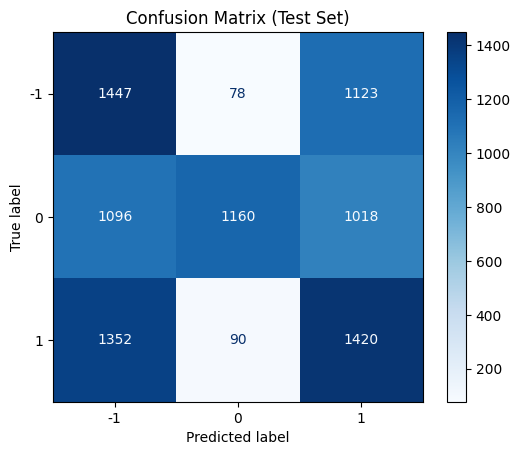

In [68]:
# Confusion Matrix for Test Set

# Define the expected labels (assuming 0 maps to -1, 1 maps to 0, 2 maps to 1)
expected_labels = [0, 1, 2] 
# Define the labels to display on the plot axes
display_labels = [-1, 0, 1] 

# Calculate confusion matrix using the expected numerical labels
cm = confusion_matrix(y_test, y_pred_test, labels=expected_labels) 

# Display the confusion matrix using the desired display labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Test Set)')
plt.show()

# Feature Importance

Feature importance scores indicate how much each feature contributed to the model's predictions. Higher scores mean the feature was more influential.

**Note:** Ensure you are plotting importance for the model you used for prediction (`chosen_model`).

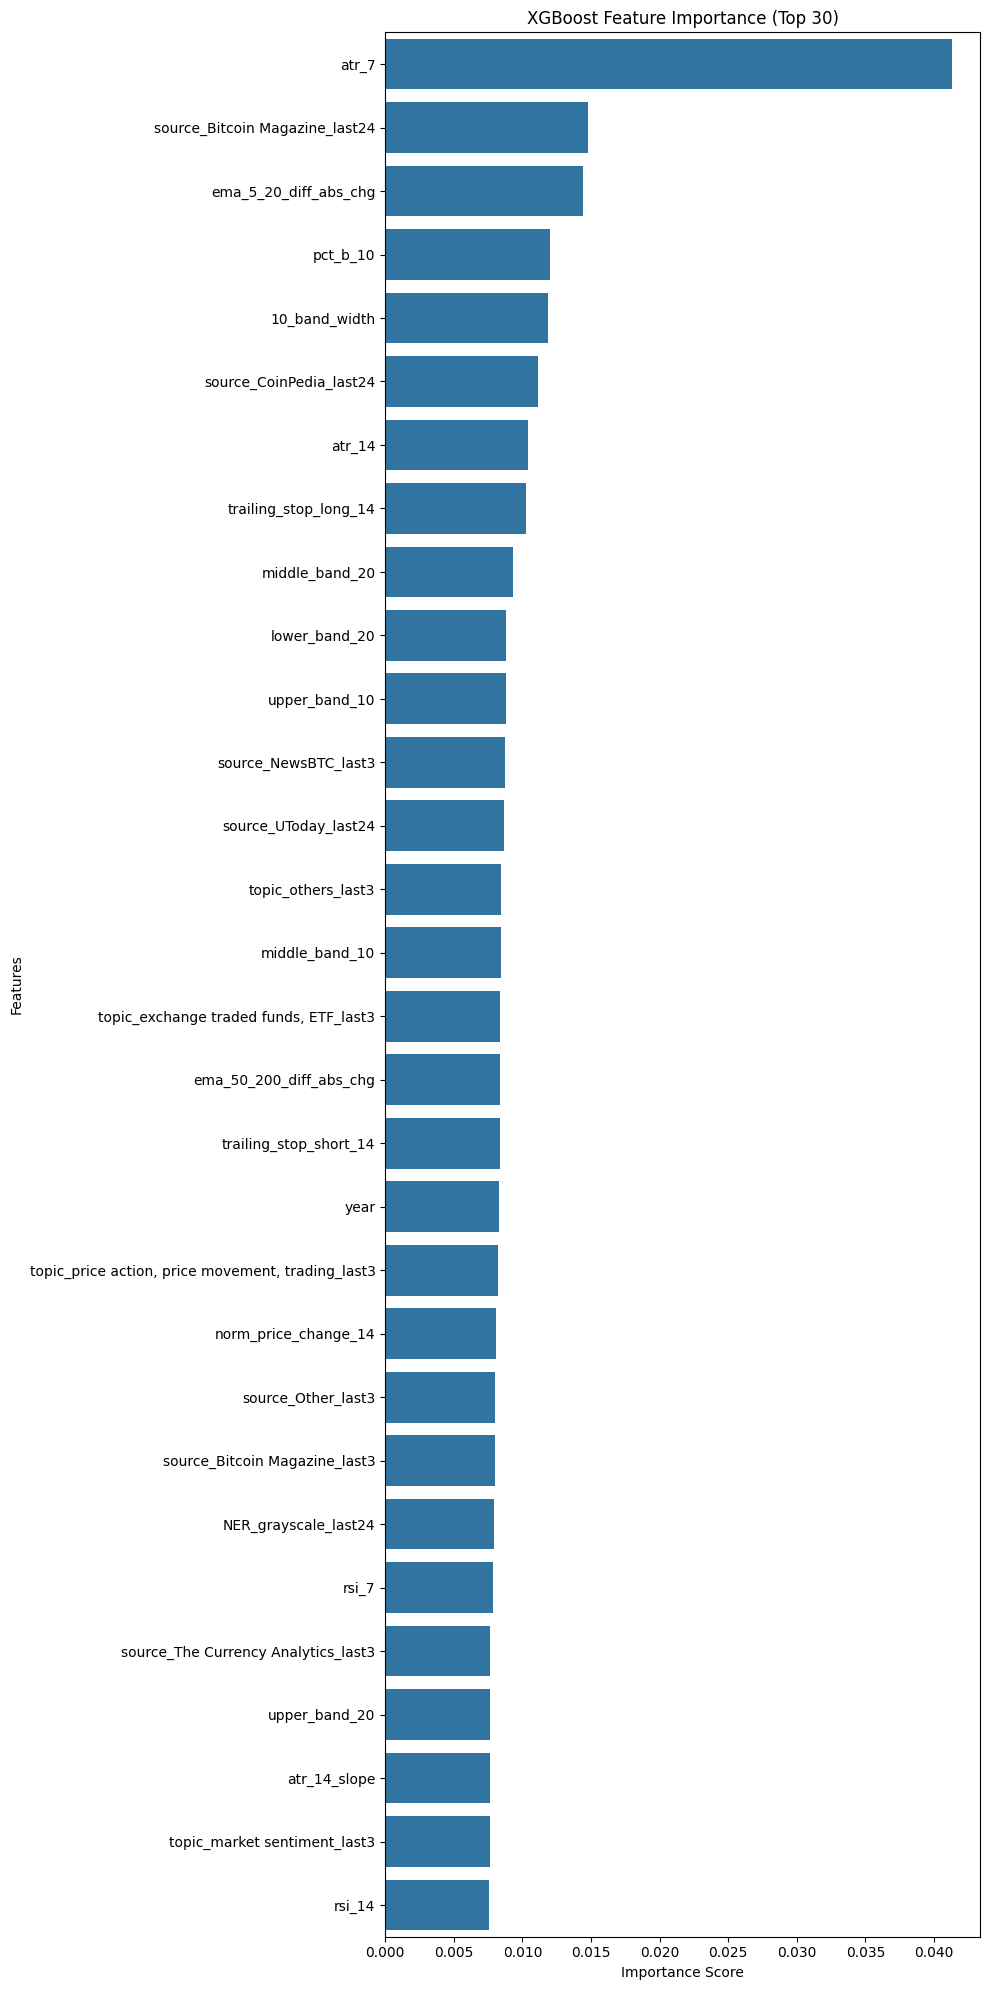

In [62]:
feature_importances = pd.Series(chosen_model.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 20)) # Adjust figure size as needed
sns.barplot(x=feature_importances.head(30), y=feature_importances.head(30).index) # Display top 30
plt.title('XGBoost Feature Importance (Top 30)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Further Steps to Consider

1.  **Feature Selection:** Based on the feature importance plot, consider removing features with very low importance scores and retraining the model.
2.  **Feature Scaling:** Although XGBoost is generally robust to feature scaling, sometimes scaling features (e.g., using `StandardScaler` or `MinMaxScaler`) can help, especially if using regularization or if features have vastly different ranges.
3.  **More Extensive Tuning:** Explore a wider range of hyperparameters or use `RandomizedSearchCV` if `GridSearchCV` is too computationally expensive.
4.  **Class Imbalance:** The target classes might be imbalanced. Consider techniques like adjusting `scale_pos_weight` (for binary) or using class weights in the `fit` method (if supported, or use sampling techniques like SMOTE). Balanced accuracy is a good metric to monitor.
5.  **Check Data Stationarity:** Ensure that the time series features used are stationary.
6.  **Probability Threshold Tuning:** Instead of using the default 0.5 threshold (implicit in `.predict()`), analyze the probabilities from `.predict_proba()` and potentially set different thresholds for converting probabilities to class labels, especially if the cost of misclassification differs between classes.

# Backtest

In [69]:
y_pred_test

array([0, 2, 1, ..., 2, 2, 2], shape=(8784,))

## Signal

In [70]:
signal = pd.DataFrame(y_pred_test, index=X_test.index, columns=['signal'])
signal['signal'] = signal['signal'].map({0:-1, 1:0, 2:1})

print(signal['signal'].value_counts())

signal

signal
-1    3895
 1    3561
 0    1328
Name: count, dtype: int64


,signal
2024-01-01 00:00:00,-1
2024-01-01 01:00:00,1
2024-01-01 02:00:00,0
2024-01-01 03:00:00,1
2024-01-01 04:00:00,1
...,...
2024-12-31 19:00:00,1
2024-12-31 20:00:00,1
2024-12-31 21:00:00,1
2024-12-31 22:00:00,1


Overall Annual Return: 18.67%
Overall Annual Sharpe Ratio: 0.592
Maximum Drawdown: -46.22 %
Alpha: 0.2821
Beta: 0.0533

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024        0.18667    0.503668     0.053343      0.248495       0.591962


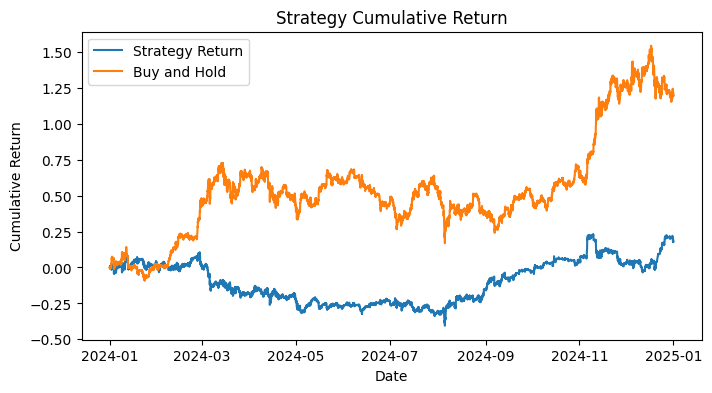

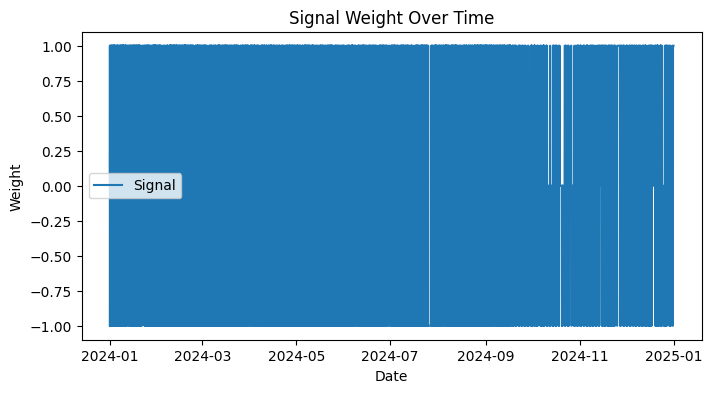

In [71]:
run_backtest(signal, freq='h')